In [1]:
import sys
sys.path.append("/home/julian/repositories")

from wingshape import WingShape
from parapolygraph import ParamPolyGraph
import numpy, math

wingshape = WingShape("P7-211221-XYZ geometry.csv")        
parapolygraph = ParamPolyGraph(wingshape, "test7.json", splineweight=0.8, legsampleleng=0.003)


In [2]:
#
# Derive the polygons from the network of nodes in UV space ( --> XYZ space by function wingshape.seval )
#
from barmesh.basicgeo import I1, Partition1, P2

parapolygraph.splineinterplegsdata()
polysnodes = parapolygraph.derivepolygons()
surfacemeshes = [ ]
for i, polynodes in enumerate(polysnodes):
    polyloop = parapolygraph.splinedpolypoints(polynodes)
    polyloopW = [ wingshape.seval(p)  for p in polyloop ]
    surfacemesh = { "polynodes":polynodes, 
                    "polyloop":polyloop,
                    "plurg":I1.AbsorbList(p[0]  for p in polyloop), 
                    "plvrg":I1.AbsorbList(p[1]  for p in polyloop),
                    "plcentre":sum(polyloop, start=P2(0,0))*(1.0/len(polyloop)), 
                    "polyloopW":polyloopW 
                  }
    surfacemeshes.append(surfacemesh)


In [3]:
#
# We need to identify and number the polygons (and some of the edges) appropriately 
# So that we can make the differential offsetting of them
#

#surfacemeshes.sort(key=lambda x: -x["plcentre"].v + x["plcentre"].u*0.05)
#print("{%s}" % ",\n\t".join("'s%d':%s" % (i, "(%.3f, %.3f)" % surfacemesh["plcentre"])  for i, surfacemesh in enumerate(surfacemeshes) ))

patchnamelookups = {   
    's0':(0.851, 0.865),
    's1':(3.907, 0.864),
    's2':(0.207, 0.106),
    's3':(0.622, 0.106),
    's4':(1.045, 0.106),
    's5':(1.481, 0.106),
    's6':(2.158, 0.106),
    's7':(3.484, 0.106),
    's8':(4.734, 0.106),
    's9':(5.612, 0.106),
    's10':(0.851, -0.294),
    's11':(3.907, -0.294),
    's12':(0.415, -0.913),
    's13':(1.266, -0.913),
    's14':(3.394, -0.827),
    's15':(4.082, -1.073) }

for surfacemesh in surfacemeshes:
    surfacemesh["patchname"] = min(((surfacemesh["plcentre"] - P2(*p)).Len(), name)  for name, p in patchnamelookups.items())[1]
assert len(set(surfacemesh["patchname"]  for surfacemesh in surfacemeshes)) == len(patchnamelookups)


In [4]:
#
# Calculate the offsets of the polygons based on a common rectangular subdivision spacing xpartA, xpartB
#

radoffset = 0.006
uspacing, vspacing = 0.02, 0.02

from barmesh.tribarmes import TriangleBarMesh, TriangleBar, MakeTriangleBoxing
from wingflatten_barmeshfuncs import ImplicitAreaBallOffsetOfClosedContour
#from barmesh import implicitareaballoffset
from wingflatten_barmeshfuncs import MakeRectBarmeshForWingParametrization
from barmesh.barmeshslicer import BarMeshSlicer
from barmesh.mainfunctions import nodewithinpairs, BarMeshContoursN
from barmesh.basicgeo import I1, Partition1

urgA, vrgA = I1(*wingshape.urange).Inflate(0.06), I1(*wingshape.vrange).Inflate(0.06)
xpartA = Partition1(urgA.lo, urgA.hi, int(urgA.Leng()/uspacing + 2))
ypartA = Partition1(vrgA.lo, vrgA.hi, int(vrgA.Leng()/vspacing + 2))

def SubPartition(part, vlo, vhi):
    res = Partition1(0, 1, 2)
    ilo, ihi = part.GetPartRange(vlo, vhi)
    res.vs = part.vs[ilo:ihi+2]
    res.lo, res.hi = res.vs[0], res.vs[-1]
    res.nparts = ihi - ilo + 1
    assert len(res.vs) == res.nparts + 1
    assert res.lo < vlo < vhi < res.hi, (res.lo , vlo , vhi , res.hi)
    return res

for i in range(len(surfacemeshes)):
    print("\nStarting", i)
    surfacemesh = surfacemeshes[i]
    polyloop, polyloopW = surfacemesh["polyloop"], surfacemesh["polyloopW"]
    urg = I1.AbsorbList(p[0]  for p in polyloop).Inflate(0.05)
    vrg = I1.AbsorbList(p[1]  for p in polyloop).Inflate(0.05)
    xpart = SubPartition(xpartA, urg.lo, urg.hi)
    ypart = SubPartition(ypartA, vrg.lo, vrg.hi)

    iaoffset = ImplicitAreaBallOffsetOfClosedContour(polyloopW, polyloop)
    bm = MakeRectBarmeshForWingParametrization(wingshape, xpart, ypart)
    rd2 = max(uspacing, vspacing, radoffset*2) + 0.01
    contourdelta = min(uspacing, vspacing)*0.2
    bms = BarMeshSlicer(bm, iaoffset, rd=radoffset, rd2=rd2, contourdotdiff=0.95, contourdelta=contourdelta, lamendgap=0.001, strictlyplanarbarmesh=False)

    #bms.initializecutsanddistances()
    bms.fullmakeslice()

    surfacemesh["barmeshoffset"] = bm
    surfacemesh["xpart"] = xpart
    surfacemesh["ypart"] = ypart

    nxs = xpart.nparts + 1
    for iy in range(ypart.nparts + 1):
        for ix in range(nxs):
            assert bm.nodes[iy*nxs + ix].sp == P2(xpart.vs[ix], ypart.vs[iy])
    


Starting 0
make triangle boxing at 0.047043302883781335
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 3040 nodes
do splitbarsdirectionchangesR on 5953 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  228
nsegs: 252 bad: 0 working: 0
116 [20, 25, 20, 5, 15, 15, 3, 5, 0, 8, 0, 0, 0, 0]

Starting 1
make triangle boxing at 0.04245011031816404
make triangle boxing at 0.06165027625633657
MakePointZoneRFS done on 5016 nodes
do splitbarsdirectionchangesR on 9782 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  478
nsegs: 490 bad: 0 working: 0
58 [15, 5, 10, 0, 13, 0, 5, 0, 10, 0, 0, 0, 0]

Starting 2
make triangle boxing at 0.052358552582613564
make triangle boxing at 0.09837810040904771
MakePointZoneRFS done on 1664 nodes
do splitbarsdirectionchangesR on 3244 bars
done splitbarsdirectionchangesR
Ready for barpolycutsrounds  142
nsegs: 165 bad: 0 working: 0
109 [10, 10, 20, 5, 8, 3, 25, 5, 8, 5, 5, 5, 0, 0, 0, 0, 0]

Starting 3
make tri

In [120]:
from barmesh import barmesh
from wingflatten_barmeshfuncs import findallnodesandpolys, cpolytriangulate

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    bm = surfacemesh["barmeshoffset"]
    xpart = surfacemesh["xpart"]
    ypart = surfacemesh["ypart"]
    contsN, topbars = BarMeshContoursN(bm, barmesh.PZ_BEYOND_R)
    assert len(contsN) == 1
    surfacemesh["offsettopbar"] = topbars[0]
    outercont = contsN[0]
    outercont.append(outercont[0])
    surfacemesh["offsetloopuv"] = [n.sp for n in outercont]
    surfacemesh["offsetlooppts"] = [n.p for n in outercont]
    tnodes, cpolys = findallnodesandpolys(bm)
    ptsF = [ node.sp  for node in tnodes ]
    surfacemesh["pts"] = numpy.array([ node.p  for node in tnodes ])
    surfacemesh["uvpts"] = uvpts = numpy.array(ptsF)
    tris = [ ]
    for cpoly in cpolys:
        tris.extend(cpolytriangulate(ptsF, cpoly))

    surfacemesh["tris"] = numpy.array(tris)
    surfacemesh["offsetloopI"] = [n.i for n in outercont]

    cpolycolumns = [ [ ]  for ix in range(xpart.nparts) ]
    tnodes, cpolys = findallnodesandpolys(bm)
    for cpoly in cpolys:
        cpt = sum((P2(*uvpts[ci]) for ci in cpoly), P2(0,0))*(1.0/len(cpoly))
        cpolycolumns[xpart.GetPart(cpt.u)].append((cpt, cpoly))
    surfacemesh["cpolycolumns"] = cpolycolumns
    
    print(i, len(ptsF), len(tris))


0 2499 4744
1 4076 7660
2 1335 2503
3 12347 24126
4 1145 2138
5 7080 13716
6 4921 9148
7 712 1304
8 1513 2851
9 4874 9449
10 678 1243
11 679 1243
12 1611 3000
13 678 1241
14 2334 4463
15 2276 4353


In [56]:
#
# Call the surface flattener (produces surfacemesh["fpts"], "triareas", "ftriareas")
#

#freecadappimage = "/home/timbo/software/FreeCAD_0.19-24054-Linux-Conda_glibc2.12-x86_64.AppImage"
# fetch from: wget https://github.com/FreeCAD/FreeCAD/releases/download/0.19_pre/FreeCAD_0.19-24267-Linux-Conda_glibc2.12-x86_64.AppImage
freecadappimage = "freecad"   # nixos install

from parapolygraph import trimeshesflattener
trimeshesflattener(surfacemeshes, freecadappimage)


>>> >>> >>> >>> >>> >>> >>> >>> >>> ... ... ... ... ... ... ... ... >>> >>> 
>>> 

[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]
mesh (pts=2499, tris=4744) flattened
mesh (pts=4076, tris=7660) flattened
mesh (pts=1335, tris=2503) flattened
mesh (pts=12347, tris=24126) flattened
mesh (pts=1145, tris=2138) flattened
mesh (pts=7080, tris=13716) flattened
mesh (pts=4921, tris=9148) flattened
mesh (pts=712, tris=1304) flattened
mesh (pts=1513, tris=2851) flattened
mesh (pts=4874, tris=9449) flattened
mesh (pts=678, tris=1243) flattened
mesh (pts=679, tris=1243) flattened
mesh (pts=1611, tris=3000) flattened
mesh (pts=678, tris=1241) flattened
mesh (pts=2334, tris=4463) flattened
mesh (pts=2276, tris=4353) flattened
[FreeCAD Console mode <Use Ctrl-D (i.e. EOF) to exit.>]



In [77]:
#
# Rotate and move the flat pieces produce the exploded diagram
#

def orientation(ptfs, polyi):
    polyi = surfacemesh["offsetloopI"]
    jbl, ptbl = min(enumerate(ptfs[i]  for i in polyi), key=lambda X:(X[1][1], X[1][0]))
    ptblFore = ptfs[polyi[(jbl+1)%len(polyi)]]
    ptblBack = ptfs[polyi[(jbl+len(polyi)-1)%len(polyi)]]
    angFore = P2(ptblFore[0]-ptbl[0], ptblFore[1]-ptbl[1]).Arg()
    angBack = P2(ptblBack[0]-ptbl[0], ptblBack[1]-ptbl[1]).Arg()
    return (angBack < angFore)

for surfacemesh in surfacemeshes:
    ptsF = surfacemesh["fpts"]*(1,-1)   # reflect in Y using numpy.array multiplication
    offsetloopuv = surfacemesh["offsetloopuv"]
    offsetloopptsF = [ P2(ptsF[i][0], ptsF[i][1])  for i in surfacemesh["offsetloopI"] ]
    offsetloopuvCentre = sum(offsetloopuv, start=P2(0,0))*(1.0/len(offsetloopuv))
    offsetloopptsFCentre = sum(offsetloopptsF, start=P2(0,0))*(1.0/len(offsetloopptsF))
    voff = offsetloopuvCentre - offsetloopptsFCentre
    
    # this proves all the polygons are reflected
    orientOrg = orientation(surfacemesh["uvpts"], surfacemesh["offsetloopI"])
    orientReflFlatttened = orientation(ptsF, surfacemesh["offsetloopI"])
    assert orientOrg == orientReflFlatttened
    
    # try and rotate so we align with the first edge
    i0 = surfacemesh["offsetloopI"][-10]
    i1 = surfacemesh["offsetloopI"][-5]
    #v = P2(*surfacemesh["uvpts"][i1]) - offsetloopuvCentre
    #vF = P2(*ptsF[i1]) - offsetloopptsFCentre
    v = P2(*surfacemesh["uvpts"][i1]) - P2(*surfacemesh["uvpts"][i0])
    vF = P2(*ptsF[i1]) - P2(*ptsF[i0])
    
    xv = P2.ZNorm(P2(P2.Dot(vF, v), P2.Dot(P2.APerp(vF), v)))
    yv = P2.APerp(xv)
    
    explodev = (offsetloopuvCentre - P2(3, 0))*0.8
    if surfacemesh["patchname"] == "s14":
        offsetloopuvCentre -= P2(1.0, -0.3)
    def transF(p):
        p0 = p - offsetloopptsFCentre
        return xv*p0[0] + yv*p0[1] + offsetloopuvCentre + explodev
    surfacemesh["fptsT"] = fptsT = numpy.array([ transF(p)  for p in ptsF ])
    vFT = P2(*surfacemesh["fptsT"][i1]) - P2(*surfacemesh["fptsT"][i0])
    #print(v.Arg(), vF.Arg(), vFT.Arg())
    surfacemesh["textpos"] = offsetloopuvCentre + explodev



<IPython.core.display.Javascript object>


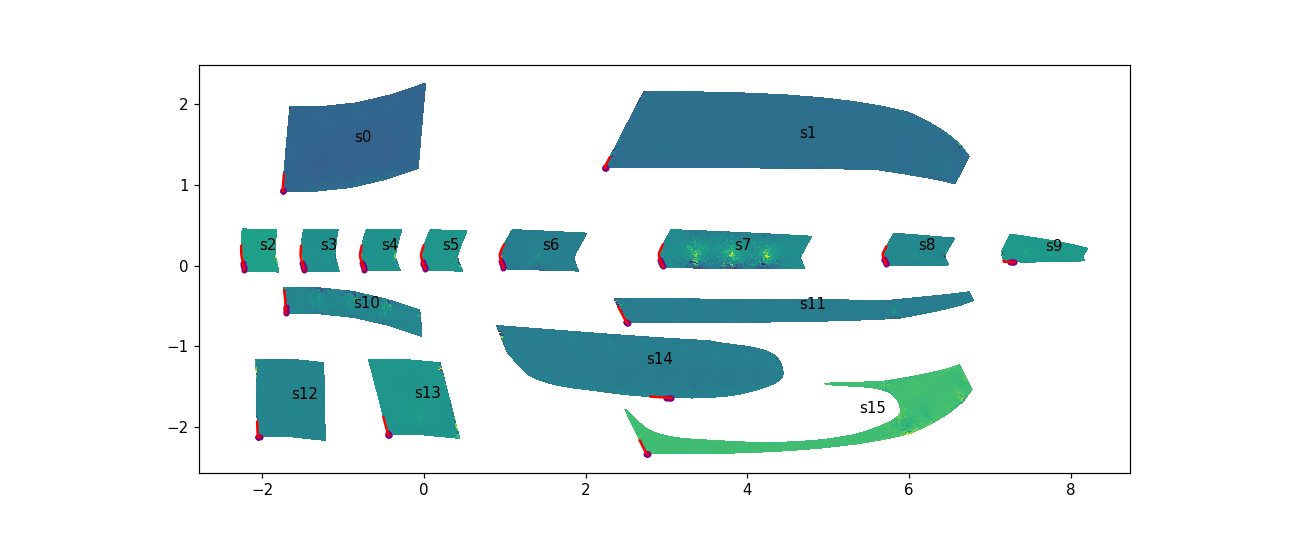

In [259]:
# 
# Exploded diagram of the flattened pieces
# 

%matplotlib notebook

plt.figure(figsize=(12,5))

for surfacemesh in surfacemeshes:
    fpts = surfacemesh["fptsT"]
    #fpts = surfacemesh["uvpts"]

    X = fpts[:,0]
    Y = fpts[:,1]
    areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
    plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange)

    plt.text(sum(X)/len(X), sum(Y)/len(Y), surfacemesh["patchname"])

    polyi = surfacemesh["offsetloopI"]
    contour = numpy.array([ fpts[i]  for i in polyi ])
    plt.plot(contour[:15,0], contour[:15,1], color="red", linewidth=1.6)
    plt.scatter(contour[:5,0], contour[:5,1], color="purple", marker=".")

plt.gca().autoscale()
plt.gca().set_aspect("equal")
#plt.colorbar()


<IPython.core.display.Javascript object>


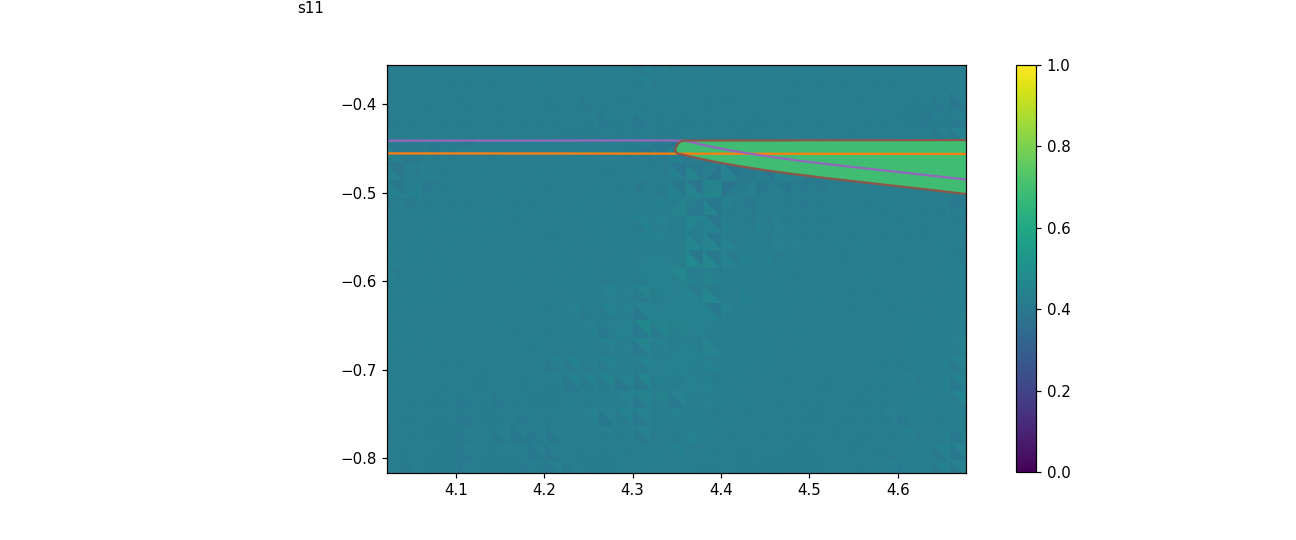

In [263]:
%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(12,5))

for surfacemesh in surfacemeshes:
    fpts = surfacemesh["uvpts"]

    X = fpts[:,0]
    Y = fpts[:,1]
    areachange = surfacemesh["triareas"]/surfacemesh["ftriareas"]
    plt.tripcolor(X, Y, surfacemesh["tris"], facecolors=areachange)

    plt.text(sum(X)/len(X), sum(Y)/len(Y), surfacemesh["patchname"])

    polyi = surfacemesh["offsetloopI"]
    contour = numpy.array([ fpts[i]  for i in polyi ])
    plt.plot(contour[:15,0], contour[:15,1], color="red", linewidth=1.6)
    plt.scatter(contour[:5,0], contour[:5,1], color="purple", marker=".")

    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
    
plt.gca().autoscale()
plt.gca().set_aspect("equal")
plt.colorbar()


In [113]:
len(surfacemesh["tris"])


9148

<IPython.core.display.Javascript object>


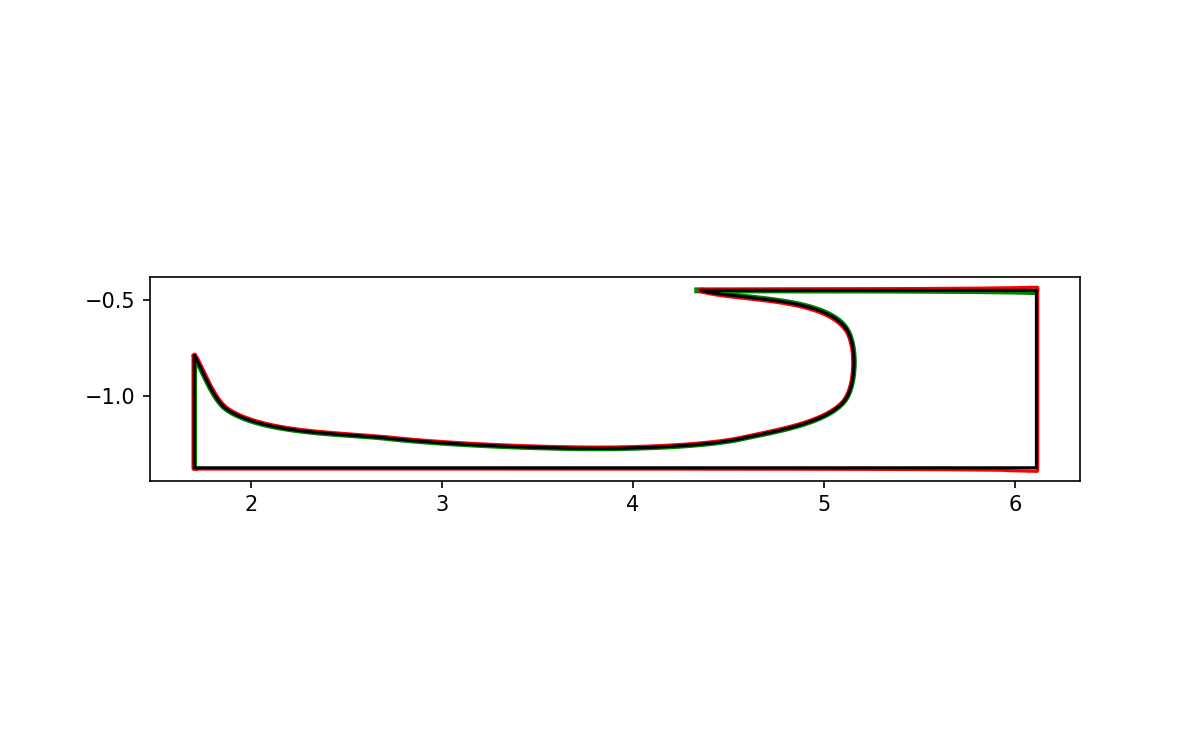

(P2(1.7134861721695147, -0.795707545021052), [4212, 4221, 4904, 4725, 3092])
(P2(1.7040759209988539, -0.7828324066400745), [4917, 4897, 4209])
(P2(1.7040759209988539, -0.7828324066400745), [4917, 4897, 4209])
(P2(1.7040759209988539, -0.7828324066400745), [4917, 4897, 4209])
(P2(1.7040759209988539, -0.7828324066400745), [4917, 4897, 4209])
(P2(1.7040759209988539, -0.7828324066400745), [4917, 4897, 4209])
(P2(1.7040759209988539, -0.7828324066400745), [4917, 4897, 4209])
(P2(1.7040759209988539, -0.7828324066400745), [4917, 4897, 4209])
(P2(6.112962327621315, -0.4388404693933806), [4208, 4888, 4901, 4217])
(P2(6.112962327621315, -0.4388404693933806), [4208, 4888, 4901, 4217])
(P2(6.112962327621315, -0.4388404693933806), [4208, 4888, 4901, 4217])
(P2(6.116833784348776, -0.4439362872473419), [4908, 4905, 4223])
(P2(6.114397540862742, -0.45172078465695265), [4223, 4905, 4799, 4119, 4208, 4217, 4214])
(P2(6.114397540862742, -0.45172078465695265), [4223, 4905, 4799, 4119, 4208, 4217, 4214])
(P2

In [126]:
# 
# projecting UV shapes into flattened area where cell is complete
# 

%matplotlib notebook

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection

from barmesh.basicgeo import I1, Partition1, P2, Along

plt.figure(figsize=(8,5))

bFlattenedPatches = False
I = 6
surfacemesh = surfacemeshes[I]
bm, xpart, ypart = surfacemesh["barmeshoffset"], surfacemesh["xpart"], surfacemesh["ypart"]


# uvpts is original parametric space, pts is 3D space, fpts is flattened space, fptsT is rotated and moved flattened piece
uvpts = surfacemesh["uvpts"]
fptsT = surfacemesh["fptsT"] if bFlattenedPatches else surfacemesh["uvpts"]

polyi = surfacemesh["offsetloopI"]
polyloop = surfacemesh["polyloop"]
cpolycolumns = surfacemesh["cpolycolumns"]

if bFlattenedPatches:
    sps = [ fptsT[k]  for k in polyi ]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps], color="red")
else:
    sps = [ uvpts[k]  for k in polyi ]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps], color="red")
    plt.plot([sp[0] for sp in polyloop], [sp[1] for sp in polyloop], color="black")

nxs = xpart.nparts + 1
def nodesixy(ix, iy):
    assert bm.nodes[(iy+1)*nxs + ix+1].sp == P2(xpart.vs[ix+1], ypart.vs[iy+1])
    return { "n00":bm.nodes[ix + iy*nxs], "n01":bm.nodes[ix+1 + iy*nxs], 
             "n10":bm.nodes[ix + (iy+1)*nxs], "n11":bm.nodes[ix+1 + (iy+1)*nxs] }

def shiftToNewIfBetter(ix, iy, nn, c0, c1, vix, viy):
    ixS, iyS = ix+vix, iy+viy
    if 0 <= ixS < xpart.nparts and 0 <= iyS < ypart.nparts:
        if nn[c0].i == -1 and nn[c1].i == -1:
            nnS = nodesixy(ixS, iyS)
            if not (nnS[c0].i == -1 and nnS[c1].i == -1):
                return ixS, iyS, nnS
    return ix, iy, nn
        
def nodesixyShift(ix, iy):
    nn = nodesixy(ix, iy)
    ix, iy, nn = shiftToNewIfBetter(ix, iy, nn, "n00", "n10", -1, 0)
    ix, iy, nn = shiftToNewIfBetter(ix, iy, nn, "n01", "n11", 1, 0)
    ix, iy, nn = shiftToNewIfBetter(ix, iy, nn, "n00", "n01", 0, -1)
    ix, iy, nn = shiftToNewIfBetter(ix, iy, nn, "n10", "n11", 0, 1)
    return nn

def projectspbarmeshF(sp):
    if not (xpart.lo <= sp[0] <= xpart.hi and ypart.lo <= sp[1] <= ypart.hi):
        return None
    ix, iy = xpart.GetPart(sp[0]), ypart.GetPart(sp[1])
    if len(cpolycolumns[ix]) == 0:
        return None
    cc = min((cc  for cc in cpolycolumns[ix]), key=lambda X: (X[0] - sp).Len())
    print(cc)
    nn = nodesixy(ix, iy)
    if nn["n00"] == -1 and nn["n01"] == -1 and nn["n10"] == -1 and nn["n11"] == -1:
        return None
    
    nn = nodesixyShift(ix, iy)

    
    assert bm.nodes[iy*nxs + ix].sp == P2(xpart.vs[ix], ypart.vs[iy])
    if nn["n11"].i == -1:
        n00, n01, n10 = nn["n00"], nn["n01"], nn["n10"]
    elif nn["n01"].i == -1:
        n00, n01, n10 = nn["n01"], nn["n00"], nn["n11"]
    elif nn["n10"].i == -1:
        n00, n01, n10 = nn["n10"], nn["n11"], nn["n00"]
    elif nn["n00"].i == -1:
        n00, n01, n10 = nn["n11"], nn["n10"], nn["n01"]
    else:
        n00, n01, n10 = nn["n00"], nn["n01"], nn["n10"]
    assert n00.sp.v == n01.sp.v and n00.sp.u == n10.sp.u
    lamx = (sp[0] - n00.sp[0])/(n01.sp[0] - n00.sp[0])
    lamy = (sp[1] - n00.sp[1])/(n10.sp[1] - n00.sp[1])
    if n00.i != -1 and n01.i != -1 and n10.i != -1:
        pf00 = P2(*fptsT[n00.i])
        vecfx, vecfy = P2(*fptsT[n01.i]) - pf00, P2(*fptsT[n10.i]) - pf00
        return pf00 + vecfx*lamx + vecfy*lamy
    if n00.i == -1 and n01.i == -1 and n10.i == -1:
        return None
    if bFlattenedPatches:
        return None
    return sp

def sliceupatnones(seq):
    res = [ [ ] ]
    for s in seq:
        if s is None:
            if res[-1]:
                res.append([])
        else:
            res[-1].append(s)
    if not res[-1]:
        res.pop()
    return res


for J in range(len(surfacemeshes)):
    if J == I:  continue
    #J = 5
    surfacemeshJ = surfacemeshes[J]
    polyiJ = surfacemeshJ["offsetloopI"]
    fptsJ = surfacemeshJ["uvpts"]
    spsJ = [ fptsJ[i]  for i in polyiJ ]
    spsJF = [ projectspbarmeshF(P2(*sp))  for sp in spsJ ]
    plt.gca().add_collection(LineCollection(sliceupatnones(spsJF), color="green"))

plt.gca().autoscale()
plt.gca().set_aspect("equal")


In [264]:
#
# Now output to the dxf file
#

import ezdxf, os

AAMA_CUT = "1"
AAMA_DRAW = "8"
AAMA_INTCUT = "11"

outputfilename = "test.dxf"
dxfversion = "R12"
breflY = False

def convvectoez(pt, breflY):
    return ezdxf.math.Vec3(pt[0]*1000, -pt[1]*1000 if breflY else pt[1]*1000, 0.0)

blockbasename = os.path.splitext(os.path.split(outputfilename)[1])[0]
doc = ezdxf.new(dxfversion)
aamacutlayer = doc.layers.new("1", {"color":1})
aamadrawlayer = doc.layers.new("8", {"color":4})
aamaintcutlayer = doc.layers.new("11", {"color":3})

for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    fpts = surfacemesh["fptsT"]
    blockname = blockbasename+"-"+surfacemesh["patchname"]
    polyi = surfacemesh["offsetloopI"]
    contour = [ fpts[i]  for i in polyi ]
    ptsseq = [ convvectoez(p, breflY)  for p in contour ]
    block = doc.blocks.new(name=blockname)
    contourcentre = ezdxf.math.Vec3((min(p.x  for p in ptsseq) + max(p.x  for p in ptsseq))/2, 
                                    (min(p.y  for p in ptsseq) + max(p.y  for p in ptsseq))/2, 0)
    cptsseq = [ pt - contourcentre  for pt in ptsseq ]
    block.add_polyline2d(cptsseq, dxfattribs={ "layer":aamacutlayer.dxf.name })
    msp = doc.modelspace()
    dxfattribs = {'rotation': 0, 'linetype':'BYLAYER' }
    k = msp.add_blockref(blockname, contourcentre, dxfattribs=dxfattribs)

doc.set_modelspace_vport(height=2300, center=(1800, 900))
doc.saveas(outputfilename)


In [ ]:
    nxs = xpart.nparts + 1
    for iy in range(ypart.nparts + 1):
        for ix in range(nxs):
            assert bm.nodes[iy*nxs + ix].sp == P2(xpart.vs[ix], ypart.vs[iy])


<IPython.core.display.Javascript object>


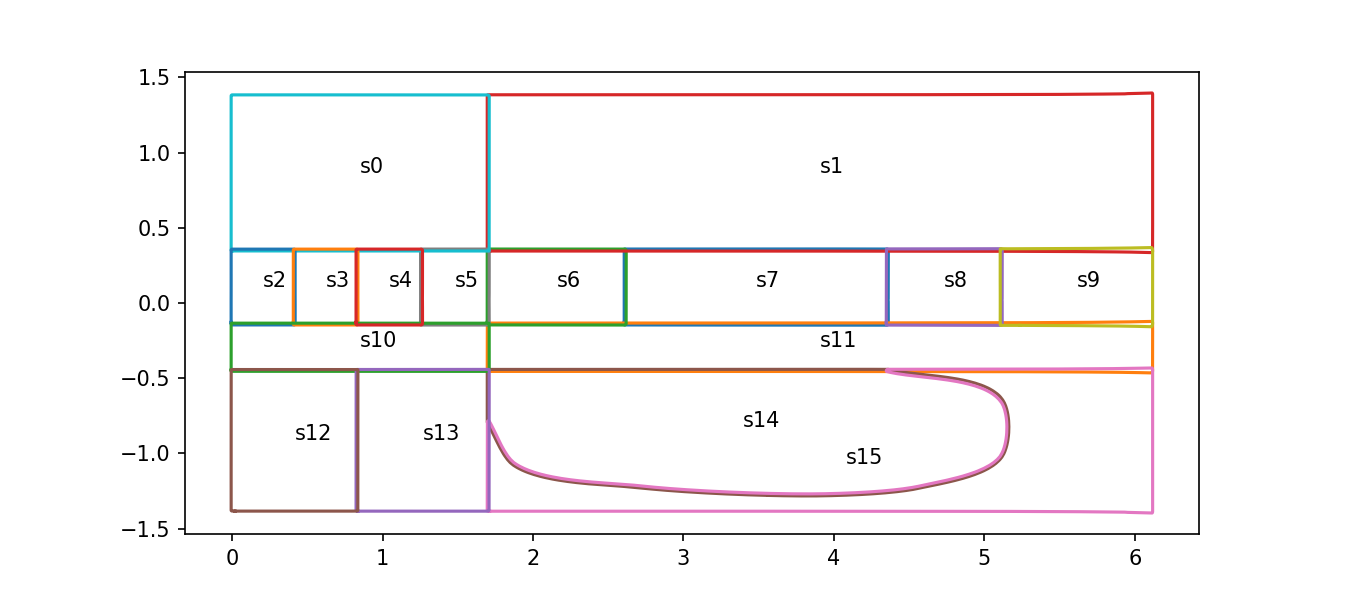

In [45]:
%matplotlib notebook 

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(figsize=(9,4))
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    sps = surfacemesh["offsetloopuv"]
    plt.plot([sp[0] for sp in sps], [sp[1] for sp in sps])
    plt.gca().text(surfacemesh["plcentre"][0], surfacemesh["plcentre"][1], surfacemesh["patchname"])
plt.gca().autoscale()
plt.gca().set_aspect("equal")


In [41]:
surfacemeshes[0]["patchname"]

's7'

<IPython.core.display.Javascript object>


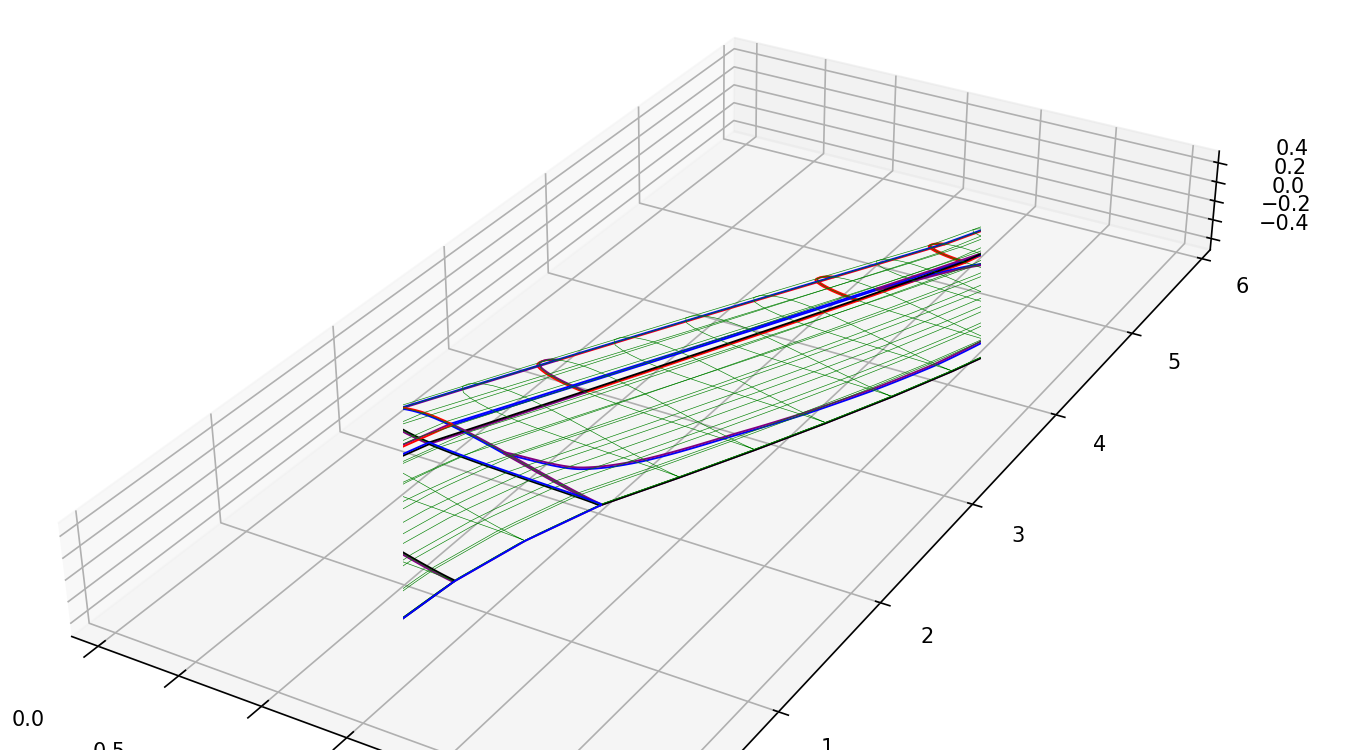

(0.0, 6.0)

In [21]:
%matplotlib notebook

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy

def flipyz(p):
    return (p.x, p.z, p.y)

fig = plt.figure(figsize=(9,5))
ax3d = fig.add_subplot(1,1,1, projection='3d')
ax3d.set_box_aspect([1,2,0.2], zoom=2.3)

ax3d.add_collection(Line3DCollection(wingshape.linesegmentnetflipyz(flipyz), color="green", linewidth=0.3))

cols = ["red", "blue", "purple", "black"]
for i in range(len(surfacemeshes)):
    surfacemesh = surfacemeshes[i]
    ps = surfacemesh["offsetlooppts"]
    segpolys = [ ]
    segpolys.append([flipyz(p)  for p in ps])
    lp3d = Line3DCollection(segpolys, color=cols[0], linewidth=0.9)
    ax3d.add_collection(lp3d)
    cols = cols[1:]+[cols[0]]
ax3d.set_aspect('auto')
ax3d.set_clip_on(False)
ax3d.autoscale_view()
ax3d.set_xlim3d(-0.1, 3.1)
ax3d.set_zlim3d(-0.5, 0.5)
ax3d.set_ylim3d(0, 6)